<h2><center>Reframing Financial Markets as Complex Systems – Notebook</center></h2>

**Objective:**
This notebook presents an illustrative case study using European sovereign bond yield data to demonstrate how network methods can inform portfolio allocation. Specifically, we construct a network based on the correlations between sovereign bonds, where network properties—such as centrality—can be identified and subsequently used to inform additional constraints within a portfolio optimisation framework, such as a minimum-variance approach.

**Method:**
A network is formed by selecting a subset of correlations across all sovereign bonds, where each bond represents a node and each edge represents the correlation between two bonds. In this notebook, we use a maximum spanning tree approach to construct the network by choosing a subset of correlations across all sovereign bonds such that all nodes are connected, the total correlation magnitude across all included edges is maximised, and no cycles exist in the network. From this network, we form groups of nodes using centrality-based measures, which can guide portfolio weighting decisions—for example, by increasing allocations to one group of nodes and decreasing allocations to others.

**Use Case:**
This approach is useful for portfolio managers for example seeking to reduce overfitting during backtesting, especially if the portfolio includes a large number of assets. Network-based methods can reduce the sensitivity of portfolio optimisation to small-magnitude correlations, thereby improving model robustness. We emphasise that this case study represents one example of how network analysis can enhance portfolio construction. Other network-based and non-network-based techniques may also be applied to address overfitting.   

<h4><left>Data</left></h4>

We use European 10-year sovereign bond data obtained from LSEG, applying imputation where necessary to address missing values. The dataset contains daily closing yield-to-maturity observations for the 2024 calendar year. The analysis includes bonds from the following countries: Austria (AUT), Belgium (BEL), Germany (DEU), Spain (ESP), Finland (FIN), Ireland (IRL), Italy (ITA), the Netherlands (NLD), and Portugal (PRT).

**Note:** Running this analysis using LSEG data requires an individual API key. Alternatively, other data sources may be used, although results may vary depending on data quality and coverage.

In [ ]:
################################################
#Data collection and imputation
################################################
import pandas as pd
import eikon as ek 
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression 

# Set your Eikon app key
ek.set_app_key("")

# RICs for sovereign 10Y bonds (yields)
# Germany, Italy, Spain, Netherlands, Belgium, Austria, Portugal, Ireland, Finland
Bond_Rics = [
            'DE10YT=RR', 'IT10YT=RR', 'ES10YT=RR', 
            'NL10YT=RR', 'BE10YT=RR', 'AT10YT=RR', 
            'PT10YT=RR', 'IE10YT=RR', 'FI10YT=RR'  
            ]

Bond_Countries = [
                'DEU', 'ITA', 'ESP', 'NLD',
                'BEL', 'AUT', 'PRT', 'IRL', 'FIN'
                 ]

# Define date range
start_date = '2024-01-01'
end_date = '2024-12-31'

# Retrieve historical yields
BondYields = ek.get_timeseries(
            Bond_Rics,
            start_date=start_date,
            end_date=end_date,
            fields='Close',
            interval='daily'
)

imputer = IterativeImputer(estimator=LinearRegression(), max_iter=100, random_state=0) #linear regression imputation
Bond_Matrix = imputer.fit_transform(pd.DataFrame(BondYields)) #apply imputation to data

# Convert back to DataFrame with original index and column names
Bond_Matrix = pd.DataFrame(
              Bond_Matrix,
              index=BondYields.index,
              columns=BondYields.columns
              )

<h4><left>Correlation heatmap</left></h4>

From the daily bond yield-to-maturity data, we calculate the Pearson correlations between sovereign bonds over the January to December 2024 period. Across all soveregin bonds, we observe a high degree of correlation, highlighting the strong financial interdependencies among Eurozone countries. This is particularly evident between AUT and FIN, as well as AUT and the NLD, where bond yield correlations reach 0.99.

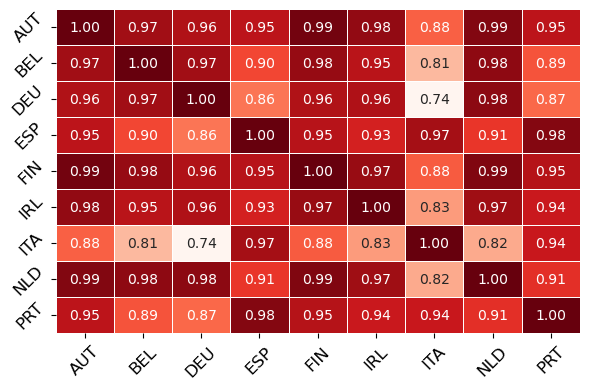

In [ ]:
################################################
#Heatmap of bond yield correlations
################################################
import matplotlib.pyplot as plt 
import seaborn as sns
Bond_Matrix.columns = Bond_Countries
Bond_Matrix = Bond_Matrix.T.sort_index().T #alphabetic ordering of labels
Pearson_Corr = Bond_Matrix.corr("pearson") #pearson correlation
plt.figure(figsize=(6, 4))
sns.heatmap(Pearson_Corr, cmap="Reds", annot=True, fmt=".2f", linewidths=.5, cbar = False, cbar_kws={'shrink': .75})
plt.title('', fontsize=15)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

<h4><left>Spanning Tree Network</left></h4>

We construct a maximum spanning tree from the correlation matrix. In this example, we use eigenvector centrality to measure the relative influence of each node within the network. Unlike degree centrality—which only reflects the number of direct connections a node has—eigenvector centrality accounts for higher-order connectivity.

Using eigenvector centrality, we identify the smallest set of nodes whose cumulative centrality accounts for 50% of the total network centrality. These nodes are assigned to the first group (shown in red), while all remaining nodes are assigned to the second group (shown in blue). This classification helps inform how weight constraints can be structured within a portfolio optimisation framework to mitigate overfitting.

Specifically, nodes with the highest centrality—those most associated with high-magnitude correlations—are assigned upper-bound constraints to reduce their portfolio weighting. Correspondingly, nodes in the second group are assigned lower-bound constraints to increase their weighting. For instance, we may impose a maximum allocation of 80% of the total portfolio weight to the high-centrality group and a minimum of 20% to the remaining nodes. By underweighting assets associated with the highest number of correlations, this reduces the overall contribution of correlated risk to portfolio variance—thereby lowering portfolio risk under a minimum-variance optimisation framework.

Our results indicate that the FIN, NLD, PRT exhibit the highest eigenvector centrality scores and are the most connected within the network. Consequently, there would be an upper bound to the weights assigned to these sovereign bonds, while a lower bound on the allocation of weights would be assigned to sovereign bonds in the other group.

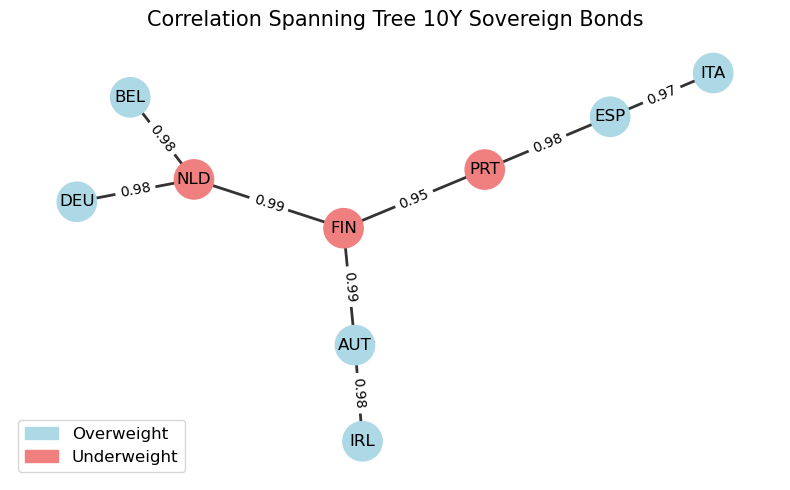

In [ ]:
################################################
#Portfolio allocation
################################################
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

Corr_Graph = nx.Graph(Pearson_Corr) 
Span_Graph = nx.maximum_spanning_tree(Corr_Graph) #maximum spanning tree 

centrality = nx.eigenvector_centrality(Span_Graph) #eigenvector centrality 
cent_total = sum(centrality.values()) #total eigenvector centrality
centrality = {k: v/cent_total for k,v in centrality.items()} #normalised evector centrality
sorted_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True) #sort node values
nodes, centralities = zip(*sorted_nodes)

# Centrality accumulation until threshold reached
threshold = 0.5 
cumulative = 0.0
highlight_nodes = set()
for node, value in sorted_nodes:
    cumulative += value
    highlight_nodes.add(node)
    if cumulative >= threshold:
        break

#Assign node colours
node_colors = ['lightcoral' if node in highlight_nodes else 'lightblue' for node in Span_Graph.nodes]

fig, ax = plt.subplots(figsize=(8, 5))
pos = nx.spring_layout(Span_Graph, k=.1, iterations=200, seed=2)

nx.draw_networkx_nodes(Span_Graph, pos, node_color=node_colors, node_size=800, alpha=1) #nodes for network 
nx.draw_networkx_edges(Span_Graph, pos, width=2, alpha=0.8) #edges for network 
nx.draw_networkx_labels(Span_Graph, pos, font_size=12, font_family='sans-serif') #add labels for network

edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in Span_Graph.edges(data=True)} #include weight labels for edges
nx.draw_networkx_edge_labels(Span_Graph, pos, edge_labels=edge_labels, font_size=10) #draw network 

long_patch = mpatches.Patch(color='lightblue', label='Overweight') #lightblue for overweight 
short_patch = mpatches.Patch(color='lightcoral', label='Underweight') #lightred for underweight
plt.legend(handles=[long_patch, short_patch], fontsize=12)

plt.axis('off')
plt.title('Correlation Spanning Tree 10Y Sovereign Bonds', fontsize=15)
plt.tight_layout()
plt.show()